## 对比head_num不同的模型在同layer时的sim差别

In [1]:
# coding=utf-8
from __future__ import absolute_import, division, print_function

import logging
import argparse
import os
import sys
import time
import datetime
import random
import numpy as np
# sys.path.append(os.path.abspath('..'))
import torch
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
try:
    from apex import amp
    from apex.parallel import DistributedDataParallel as DDP
    has_apex = True
except ImportError:
    has_apex = False
    # raise ImportError("Please install apex from https://www.github.com/nvidia/apex to run this example.")

from models.modeling import VisionTransformer, CONFIGS
from utils.scheduler import WarmupLinearSchedule, WarmupCosineSchedule
from utils.data_utils import get_loader
from utils.dist_util import *
from timm.utils import accuracy, AverageMeter
from matplotlib import pyplot as plt
from analyse.cca_core import *
from analyse.pwcca import *

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

def _plot_helper(arr, label=None, xlabel=None, ylabel=None):
    if label is not None:
        plt.plot(arr, lw=2.0, label=label)
        plt.legend(loc="best")
    else:
        plt.plot(arr, lw=2.0)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

/home/zijie_xin/anaconda3/envs/env_lxmert/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setup CUDA, GPU & distributed training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if n_gpu > 0:
    torch.cuda.manual_seed_all(seed)

提取head_num=12的模型

In [3]:
# Model & Tokenizer Setup
head_num = 12
config = CONFIGS["ViT-B_16"]
num_classes = 100
model = VisionTransformer(config, 224, zero_head=True, num_classes=num_classes)
# loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=3e-2,
                            momentum=0.9,
                            weight_decay=0)

PATH = "logs/cifar100/cifar100-b16h12/cifar100-b16h12-Latest-epoch10.pth"
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
max_accuracy = checkpoint['max_accuracy']
print("Load model from %s, epoch %d, max_accuracy %f" % (PATH, epoch, max_accuracy))


queryWeight = []
for name, param in model.named_parameters():
    # print(name, param.shape, type(param))
    if 'query.weight' in name:
        print(name, param.shape, type(param))
        queryWeight.append(param)


# 沿着第二个维度将张量分割为12个大小为[768, 64]的张量
split_tensors = [torch.chunk(queryWeight[i], head_num, dim=1) for i in range(len(queryWeight))]
w_h12 = np.zeros((12, head_num, int(768/head_num), 768))  # w[i, j]表示第i个layer的第j个head的权重
for i in range(len(queryWeight)):
    tmp_tensor = split_tensors[i]
    for j in range(head_num):
        w_h12[i, j] = tmp_tensor[j].detach().cpu().numpy().T

Load model from logs/cifar100/cifar100-b16h12/cifar100-b16h12-Latest-epoch10.pth, epoch 10, max_accuracy 92.460000
transformer.encoder.layer.0.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.1.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.2.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.3.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.4.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.5.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.6.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.7.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.l

提取head_num=2的模型

In [4]:
# Model & Tokenizer Setup
head_num = 2
config = CONFIGS["ViT-B_16-h2"]
num_classes = 100
model = VisionTransformer(config, 224, zero_head=True, num_classes=num_classes)
# loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=3e-2,
                            momentum=0.9,
                            weight_decay=0)

PATH = "logs/cifar100/cifar100-b16h2/cifar100-b16h2-Latest-epoch10.pth"
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
max_accuracy = checkpoint['max_accuracy']
print("Load model from %s, epoch %d, max_accuracy %f" % (PATH, epoch, max_accuracy))


queryWeight = []
for name, param in model.named_parameters():
    # print(name, param.shape, type(param))
    if 'query.weight' in name:
        print(name, param.shape, type(param))
        queryWeight.append(param)


# 沿着第二个维度将张量分割为2个大小为[768, 64]的张量
split_tensors = [torch.chunk(queryWeight[i], head_num, dim=1) for i in range(len(queryWeight))]
w_h2 = np.zeros((12, head_num, int(768/head_num), 768))  # w[i, j]表示第i个layer的第j个head的权重
for i in range(len(queryWeight)):
    tmp_tensor = split_tensors[i]
    for j in range(head_num):
        w_h2[i, j] = tmp_tensor[j].detach().cpu().numpy().T

Load model from logs/cifar100/cifar100-b16h2/cifar100-b16h2-Latest-epoch10.pth, epoch 10, max_accuracy 73.730000
transformer.encoder.layer.0.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.1.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.2.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.3.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.4.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.5.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.6.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.7.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.lay

提取head_num=4的模型

In [5]:
# Model & Tokenizer Setup
head_num = 4
config = CONFIGS["ViT-B_16-h4"]
num_classes = 100
model = VisionTransformer(config, 224, zero_head=True, num_classes=num_classes)
# loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=3e-2,
                            momentum=0.9,
                            weight_decay=0)

PATH = "logs/cifar100/cifar100-b16h4/cifar100-b16h4-Latest-epoch10.pth"
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
max_accuracy = checkpoint['max_accuracy']
print("Load model from %s, epoch %d, max_accuracy %f" % (PATH, epoch, max_accuracy))


queryWeight = []
for name, param in model.named_parameters():
    # print(name, param.shape, type(param))
    if 'query.weight' in name:
        print(name, param.shape, type(param))
        queryWeight.append(param)


# 沿着第二个维度将张量分割为4个大小为[768, 64]的张量
split_tensors = [torch.chunk(queryWeight[i], head_num, dim=1) for i in range(len(queryWeight))]
w_h4 = np.zeros((12, head_num, int(768/head_num), 768))  # w[i, j]表示第i个layer的第j个head的权重
for i in range(len(queryWeight)):
    tmp_tensor = split_tensors[i]
    for j in range(head_num):
        w_h4[i, j] = tmp_tensor[j].detach().cpu().numpy().T

Load model from logs/cifar100/cifar100-b16h4/cifar100-b16h4-Latest-epoch10.pth, epoch 10, max_accuracy 86.070000
transformer.encoder.layer.0.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.1.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.2.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.3.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.4.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.5.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.6.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.7.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.lay

提取head_num=8的模型

In [6]:
# Model & Tokenizer Setup
head_num = 8
config = CONFIGS["ViT-B_16-h8"]
num_classes = 100
model = VisionTransformer(config, 224, zero_head=True, num_classes=num_classes)
# loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=3e-2,
                            momentum=0.9,
                            weight_decay=0)

PATH = "logs/cifar100/cifar100-b16h8/cifar100-b16h8-Latest-epoch10.pth"
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
max_accuracy = checkpoint['max_accuracy']
print("Load model from %s, epoch %d, max_accuracy %f" % (PATH, epoch, max_accuracy))


queryWeight = []
for name, param in model.named_parameters():
    # print(name, param.shape, type(param))
    if 'query.weight' in name:
        print(name, param.shape, type(param))
        queryWeight.append(param)


# 沿着第二个维度将张量分割为8个大小为[768, 96]的张量
split_tensors = [torch.chunk(queryWeight[i], head_num, dim=1) for i in range(len(queryWeight))]
print(split_tensors[0][0].shape)
w_h8 = np.zeros((12, head_num, int(768/head_num), 768))  # w[i, j]表示第i个layer的第j个head的权重
for i in range(len(queryWeight)):
    tmp_tensor = split_tensors[i]
    for j in range(head_num):
        w_h8[i, j] = tmp_tensor[j].detach().cpu().numpy().T

Load model from logs/cifar100/cifar100-b16h8/cifar100-b16h8-Latest-epoch10.pth, epoch 10, max_accuracy 89.280000
transformer.encoder.layer.0.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.1.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.2.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.3.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.4.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.5.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.6.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.7.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.lay

提取head_num=16的模型

In [7]:
# Model & Tokenizer Setup
head_num = 16
config = CONFIGS["ViT-B_16-h16"]
num_classes = 100
model = VisionTransformer(config, 224, zero_head=True, num_classes=num_classes)
# loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=3e-2,
                            momentum=0.9,
                            weight_decay=0)

PATH = "./logs/cifar100/cifar100-b16h16/cifar100-b16h16-Latest-epoch10.pth"
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
max_accuracy = checkpoint['max_accuracy']
print("Load model from %s, epoch %d, max_accuracy %f" % (PATH, epoch, max_accuracy))


queryWeight = []
for name, param in model.named_parameters():
    # print(name, param.shape, type(param))
    if 'query.weight' in name:
        print(name, param.shape, type(param))
        queryWeight.append(param)


# 沿着第二个维度将张量分割为16个大小为[768, 64]的张量
split_tensors = [torch.chunk(queryWeight[i], head_num, dim=1) for i in range(len(queryWeight))]
w_h16 = np.zeros((12, head_num, int(768/head_num), 768))  # w[i, j]表示第i个layer的第j个head的权重
for i in range(len(queryWeight)):
    tmp_tensor = split_tensors[i]
    for j in range(head_num):
        w_h16[i, j] = tmp_tensor[j].detach().cpu().numpy().T

Load model from ./logs/cifar100/cifar100-b16h16/cifar100-b16h16-Latest-epoch10.pth, epoch 10, max_accuracy 90.900000
transformer.encoder.layer.0.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.1.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.2.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.3.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.4.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.5.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.6.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.7.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder

对每一层的head0,1计算平均相似度，发现随着层数的加深，相似度在明显减少。

说明层数越深，多头拆分出的feature层次越高，越抽象，多头之间越diversify

all_cca for head_num=4
W[0, 0] and W[0, 1] Mean all_CCA similarity 0.736754
W[1, 0] and W[1, 1] Mean all_CCA similarity 0.728772
W[2, 0] and W[2, 1] Mean all_CCA similarity 0.654833
W[3, 0] and W[3, 1] Mean all_CCA similarity 0.602631
W[4, 0] and W[4, 1] Mean all_CCA similarity 0.577293
W[5, 0] and W[5, 1] Mean all_CCA similarity 0.561093
W[6, 0] and W[6, 1] Mean all_CCA similarity 0.543405
W[7, 0] and W[7, 1] Mean all_CCA similarity 0.524952
W[8, 0] and W[8, 1] Mean all_CCA similarity 0.511897
W[9, 0] and W[9, 1] Mean all_CCA similarity 0.495197
W[10, 0] and W[10, 1] Mean all_CCA similarity 0.476287
W[11, 0] and W[11, 1] Mean all_CCA similarity 0.459750


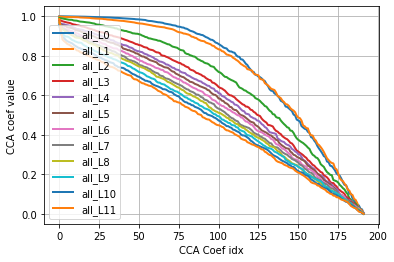

all_cca for head_num=8
W[0, 0] and W[0, 1] Mean all_CCA similarity 0.701397
W[1, 0] and W[1, 1] Mean all_CCA similarity 0.624050
W[2, 0] and W[2, 1] Mean all_CCA similarity 0.535506
W[3, 0] and W[3, 1] Mean all_CCA similarity 0.469825
W[4, 0] and W[4, 1] Mean all_CCA similarity 0.444216
W[5, 0] and W[5, 1] Mean all_CCA similarity 0.442512
W[6, 0] and W[6, 1] Mean all_CCA similarity 0.421803
W[7, 0] and W[7, 1] Mean all_CCA similarity 0.403456
W[8, 0] and W[8, 1] Mean all_CCA similarity 0.391241
W[9, 0] and W[9, 1] Mean all_CCA similarity 0.370813
W[10, 0] and W[10, 1] Mean all_CCA similarity 0.347286
W[11, 0] and W[11, 1] Mean all_CCA similarity 0.332234


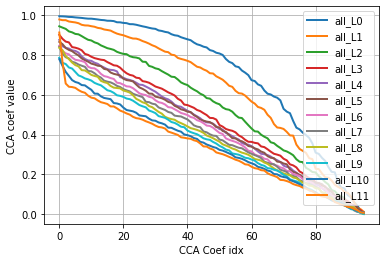

all_cca for head_num=12
W[0, 0] and W[0, 1] Mean all_CCA similarity 0.667536
W[1, 0] and W[1, 1] Mean all_CCA similarity 0.556436
W[2, 0] and W[2, 1] Mean all_CCA similarity 0.466001
W[3, 0] and W[3, 1] Mean all_CCA similarity 0.401040
W[4, 0] and W[4, 1] Mean all_CCA similarity 0.384866
W[5, 0] and W[5, 1] Mean all_CCA similarity 0.383264
W[6, 0] and W[6, 1] Mean all_CCA similarity 0.360997
W[7, 0] and W[7, 1] Mean all_CCA similarity 0.343096
W[8, 0] and W[8, 1] Mean all_CCA similarity 0.341318
W[9, 0] and W[9, 1] Mean all_CCA similarity 0.311913
W[10, 0] and W[10, 1] Mean all_CCA similarity 0.284807
W[11, 0] and W[11, 1] Mean all_CCA similarity 0.274274


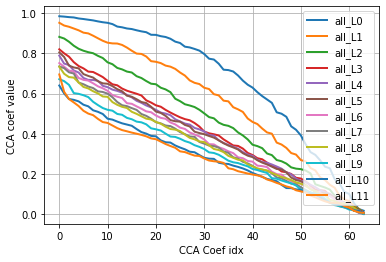

all_cca for head_num=16
W[0, 0] and W[0, 1] Mean all_CCA similarity 0.600624
W[1, 0] and W[1, 1] Mean all_CCA similarity 0.509072
W[2, 0] and W[2, 1] Mean all_CCA similarity 0.419097
W[3, 0] and W[3, 1] Mean all_CCA similarity 0.356129
W[4, 0] and W[4, 1] Mean all_CCA similarity 0.337345
W[5, 0] and W[5, 1] Mean all_CCA similarity 0.342649
W[6, 0] and W[6, 1] Mean all_CCA similarity 0.313788
W[7, 0] and W[7, 1] Mean all_CCA similarity 0.304768
W[8, 0] and W[8, 1] Mean all_CCA similarity 0.306028
W[9, 0] and W[9, 1] Mean all_CCA similarity 0.271309
W[10, 0] and W[10, 1] Mean all_CCA similarity 0.246543
W[11, 0] and W[11, 1] Mean all_CCA similarity 0.238167


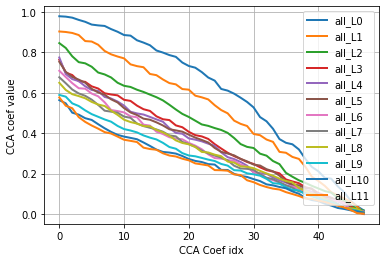

In [8]:
w_matrix = {
    2: w_h2,
    4: w_h4,
    8: w_h8,
    12: w_h12,
    16: w_h16
}

def all_cca(layer1, head1, layer2, head2, draw=True, isprint=True, head_num=12):
    w = w_matrix[head_num]
    acts1, acts2 = w[layer1, head1], w[layer2, head2]
    # print("activation shapes", acts1.shape, acts2.shape)
    results = get_cca_similarity(acts1, acts2, epsilon=1e-10, verbose=False)
    if draw:
        _plot_helper(results["cca_coef1"], "all_L%d" % (layer1), "CCA Coef idx", "CCA coef value")
    if isprint:
        print("W[%d, %d] and W[%d, %d] Mean all_CCA similarity %f" % (layer1, head1, layer2, head2, np.mean(results["cca_coef1"])))
    return np.mean(results["cca_coef1"])

# print("all_cca for head_num=2")
# for i in range(12):
#     all_cca(i, 0, i, 1, head_num=2)
# plt.grid()
# plt.show()

print("all_cca for head_num=4")
for i in range(12):
    all_cca(i, 0, i, 1, head_num=4)
plt.grid()
plt.show()

print("all_cca for head_num=8")
for i in range(12):
    all_cca(i, 0, i, 1, head_num=8)
plt.grid()
plt.show()

print("all_cca for head_num=12")
for i in range(12):
    all_cca(i, 0, i, 1, head_num=12)
plt.grid()
plt.show()

print("all_cca for head_num=16")
for i in range(12):
    all_cca(i, 0, i, 1, head_num=16)
plt.grid()
plt.show()

SVCCA提取前30维后发现，对每层的head0,head1之间的相似程度，几乎没有区别



svcca k=30 for head_num=2
W[0, 0] and W[0, 1] Mean SVCCA similarity 0.773806
W[1, 0] and W[1, 1] Mean SVCCA similarity 0.786915
W[2, 0] and W[2, 1] Mean SVCCA similarity 0.686215
W[3, 0] and W[3, 1] Mean SVCCA similarity 0.605995
W[4, 0] and W[4, 1] Mean SVCCA similarity 0.597301
W[5, 0] and W[5, 1] Mean SVCCA similarity 0.616571
W[6, 0] and W[6, 1] Mean SVCCA similarity 0.594477
W[7, 0] and W[7, 1] Mean SVCCA similarity 0.582029
W[8, 0] and W[8, 1] Mean SVCCA similarity 0.589008
W[9, 0] and W[9, 1] Mean SVCCA similarity 0.521631
W[10, 0] and W[10, 1] Mean SVCCA similarity 0.408635
W[11, 0] and W[11, 1] Mean SVCCA similarity 0.316218


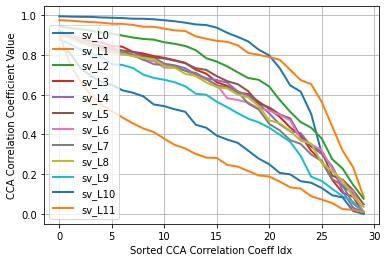

svcca 
W[0, 0] and W[0, 1] Mean SVCCA similarity 0.706439
W[1, 0] and W[1, 1] Mean SVCCA similarity 0.679340
W[2, 0] and W[2, 1] Mean SVCCA similarity 0.575963
W[3, 0] and W[3, 1] Mean SVCCA similarity 0.483950
W[4, 0] and W[4, 1] Mean SVCCA similarity 0.474758
W[5, 0] and W[5, 1] Mean SVCCA similarity 0.481639
W[6, 0] and W[6, 1] Mean SVCCA similarity 0.473081
W[7, 0] and W[7, 1] Mean SVCCA similarity 0.473936
W[8, 0] and W[8, 1] Mean SVCCA similarity 0.454564
W[9, 0] and W[9, 1] Mean SVCCA similarity 0.399460
W[10, 0] and W[10, 1] Mean SVCCA similarity 0.316319
W[11, 0] and W[11, 1] Mean SVCCA similarity 0.263097


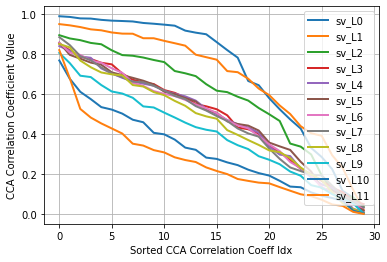

W[0, 0] and W[0, 1] Mean SVCCA similarity 0.657675
W[1, 0] and W[1, 1] Mean SVCCA similarity 0.566446
W[2, 0] and W[2, 1] Mean SVCCA similarity 0.467766
W[3, 0] and W[3, 1] Mean SVCCA similarity 0.385074
W[4, 0] and W[4, 1] Mean SVCCA similarity 0.372939
W[5, 0] and W[5, 1] Mean SVCCA similarity 0.398016
W[6, 0] and W[6, 1] Mean SVCCA similarity 0.377026
W[7, 0] and W[7, 1] Mean SVCCA similarity 0.363934
W[8, 0] and W[8, 1] Mean SVCCA similarity 0.352419
W[9, 0] and W[9, 1] Mean SVCCA similarity 0.302243
W[10, 0] and W[10, 1] Mean SVCCA similarity 0.249901
W[11, 0] and W[11, 1] Mean SVCCA similarity 0.225180


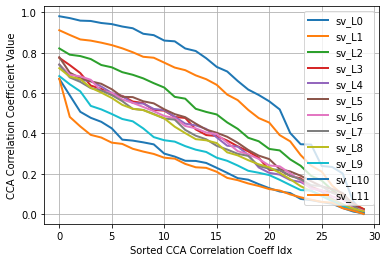

W[0, 0] and W[0, 1] Mean SVCCA similarity 0.609410
W[1, 0] and W[1, 1] Mean SVCCA similarity 0.506417
W[2, 0] and W[2, 1] Mean SVCCA similarity 0.421367
W[3, 0] and W[3, 1] Mean SVCCA similarity 0.354529
W[4, 0] and W[4, 1] Mean SVCCA similarity 0.337308
W[5, 0] and W[5, 1] Mean SVCCA similarity 0.346351
W[6, 0] and W[6, 1] Mean SVCCA similarity 0.343238
W[7, 0] and W[7, 1] Mean SVCCA similarity 0.327626
W[8, 0] and W[8, 1] Mean SVCCA similarity 0.319161
W[9, 0] and W[9, 1] Mean SVCCA similarity 0.269177
W[10, 0] and W[10, 1] Mean SVCCA similarity 0.225204
W[11, 0] and W[11, 1] Mean SVCCA similarity 0.209457


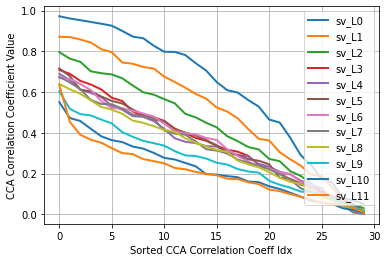

W[0, 0] and W[0, 1] Mean SVCCA similarity 0.565879
W[1, 0] and W[1, 1] Mean SVCCA similarity 0.475867
W[2, 0] and W[2, 1] Mean SVCCA similarity 0.388550
W[3, 0] and W[3, 1] Mean SVCCA similarity 0.318627
W[4, 0] and W[4, 1] Mean SVCCA similarity 0.309106
W[5, 0] and W[5, 1] Mean SVCCA similarity 0.322523
W[6, 0] and W[6, 1] Mean SVCCA similarity 0.300241
W[7, 0] and W[7, 1] Mean SVCCA similarity 0.296451
W[8, 0] and W[8, 1] Mean SVCCA similarity 0.286957
W[9, 0] and W[9, 1] Mean SVCCA similarity 0.241450
W[10, 0] and W[10, 1] Mean SVCCA similarity 0.216275
W[11, 0] and W[11, 1] Mean SVCCA similarity 0.201508


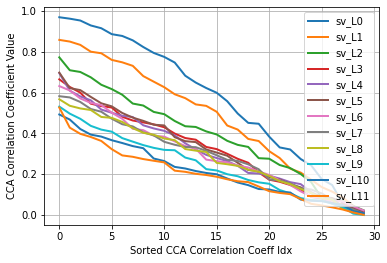

In [9]:
def svcca(layer1, head1, layer2, head2, k=20, draw=True, isprint=True, head_num=12):
    w = w_matrix[head_num]
    # Mean subtract activations
    cacts1 = w[layer1, head1] - np.mean(w[layer1, head1], axis=1, keepdims=True)
    cacts2 = w[layer2, head2] - np.mean(w[layer2, head2], axis=1, keepdims=True)

    # Perform SVD
    U1, s1, V1 = np.linalg.svd(cacts1, full_matrices=False)
    U2, s2, V2 = np.linalg.svd(cacts2, full_matrices=False)

    svacts1 = np.dot(s1[:k]*np.eye(k), V1[:k])
    # can also compute as svacts1 = np.dot(U1.T[:20], cacts1)
    svacts2 = np.dot(s2[:k]*np.eye(k), V2[:k])
    # can also compute as svacts1 = np.dot(U2.T[:20], cacts2)

    svcca_results = get_cca_similarity(svacts1, svacts2, epsilon=1e-10, verbose=False)
    if isprint:
        print("W[%d, %d] and W[%d, %d] Mean SVCCA similarity %f" % (layer1, head1, layer2, head2, np.mean(svcca_results["cca_coef1"])))
    if draw:
        _plot_helper(svcca_results["cca_coef1"], "sv_L%d" % (layer1), "Sorted CCA Correlation Coeff Idx", "CCA Correlation Coefficient Value")
    return np.mean(svcca_results["cca_coef1"])


k = 30
print("svcca k=%d for head_num=2" % (k))
for i in range(12):
    svcca(i, 0, i, 1, k=k, head_num=2)
plt.grid()
plt.show()

print("svcca ")
for i in range(12):
    svcca(i, 0, i, 1, k=k, head_num=4)
plt.grid()
plt.show()

for i in range(12):
    svcca(i, 0, i, 1, k=k, head_num=8)
plt.grid()
plt.show()

for i in range(12):
    svcca(i, 0, i, 1, k=k, head_num=12)
plt.grid()
plt.show()

for i in range(12):
    svcca(i, 0, i, 1, k=k, head_num=16)
plt.grid()
plt.show()

In [10]:
def pw_cca(layer1, head1, layer2, head2, isprint=True, head_num=12):
    w = w_matrix[head_num]
    acts1, acts2 = w[layer1, head1], w[layer2, head2]
    pwcca_mean, ws, _ = compute_pwcca(acts1, acts2, epsilon=1e-10)
    if isprint:
        print("W[%d, %d] and W[%d, %d] Mean PWCCA similarity %f" % (layer1, head1, layer2, head2, pwcca_mean))
    return pwcca_mean

print("PWCCA for head_num=2")
for i in range(12):
    pw_cca(i, 0, i, 1, head_num=2)

print("PWCCA for head_num=4")
for i in range(12):
    pw_cca(i, 0, i, 1, head_num=4)

print("PWCCA for head_num=8")
for i in range(12):
    pw_cca(i, 0, i, 1, head_num=8)


for i in range(12):
    pw_cca(i, 0, i, 1, head_num=12)

for i in range(12):
    pw_cca(i, 0, i, 1, head_num=16)

PWCCA for head_num=2
W[0, 0] and W[0, 1] Mean PWCCA similarity 0.970613
W[1, 0] and W[1, 1] Mean PWCCA similarity 0.960566
W[2, 0] and W[2, 1] Mean PWCCA similarity 0.908765
W[3, 0] and W[3, 1] Mean PWCCA similarity 0.868768
W[4, 0] and W[4, 1] Mean PWCCA similarity 0.839489
W[5, 0] and W[5, 1] Mean PWCCA similarity 0.822625
W[6, 0] and W[6, 1] Mean PWCCA similarity 0.802654
W[7, 0] and W[7, 1] Mean PWCCA similarity 0.784992
W[8, 0] and W[8, 1] Mean PWCCA similarity 0.772857
W[9, 0] and W[9, 1] Mean PWCCA similarity 0.751001
W[10, 0] and W[10, 1] Mean PWCCA similarity 0.729696
W[11, 0] and W[11, 1] Mean PWCCA similarity 0.714921
PWCCA for head_num=4
W[0, 0] and W[0, 1] Mean PWCCA similarity 0.909703
W[1, 0] and W[1, 1] Mean PWCCA similarity 0.860869
W[2, 0] and W[2, 1] Mean PWCCA similarity 0.760841
W[3, 0] and W[3, 1] Mean PWCCA similarity 0.684477
W[4, 0] and W[4, 1] Mean PWCCA similarity 0.653957
W[5, 0] and W[5, 1] Mean PWCCA similarity 0.638100
W[6, 0] and W[6, 1] Mean PWCCA simil

In [11]:
def layer_sim(type="all_cca", head_num=12):
    sim = []
    for layer in range(12):
        sims = np.zeros((head_num, head_num))
        sum = 0.0
        for i in range(head_num):
            for j in range(head_num):
                if type == "all_cca":
                    sims[i, j] = all_cca(layer, i, layer, j, draw=False, isprint=False, head_num=head_num)
                elif type == "sv_cca":
                    sims[i, j] = svcca(layer, i, layer, j, k=20, draw=False, isprint=False, head_num=head_num)
                elif type == "pw_cca":
                    sims[i, j] = pw_cca(layer, i, layer, j, isprint=False, head_num=head_num)
                sum += sims[i, j]
        sim.append(sum / (head_num * head_num))
    print(sim)
    _plot_helper(sim, 'h'+str(head_num)+'-'+type, "layer", "sim")


对同head_num的模型内部的all_cca和sv_cca进行比较

In [12]:
# layer_sim(type="all_cca", head_num=2)
# layer_sim(type="sv_cca", head_num=2)
# layer_sim(type="pw_cca", head_num=2)
# plt.grid()
# plt.show()

# layer_sim(type="all_cca", head_num=4)
# layer_sim(type="sv_cca", head_num=4)
# layer_sim(type="pw_cca", head_num=4)
# plt.grid()
# plt.show()

# layer_sim(type="all_cca", head_num=12)
# layer_sim(type="sv_cca", head_num=12)
# layer_sim(type="pw_cca", head_num=12)
# plt.grid()
# plt.show()

# layer_sim(type="all_cca", head_num=16)
# layer_sim(type="sv_cca", head_num=16)
# layer_sim(type="pw_cca", head_num=16)
# plt.grid()
# plt.show()

分别对不同head_num的模型的all_cca和sv_cca进行比较

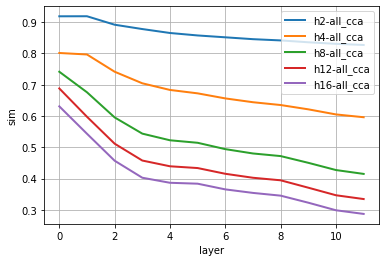

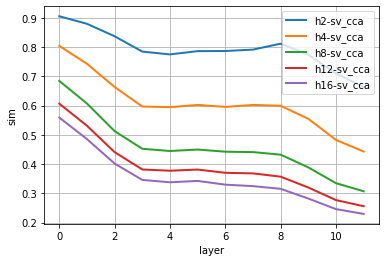

[0.9853249363261738, 0.9805322796499347, 0.9549521565740622, 0.9351955280863135, 0.9202438631770952, 0.9117554590884358, 0.901400954802599, 0.8925699582622091, 0.8865842616436443, 0.87569641345733, 0.8644816286396666, 0.8576024919593324]
[0.933144498463623, 0.8975688732200755, 0.822744458288757, 0.7689667284293964, 0.7428189290413879, 0.7315570457733428, 0.708927982462937, 0.6930484399614244, 0.6815612014902903, 0.6586249747301629, 0.6326194567460914, 0.6191505841105805]
[0.8608842587233789, 0.7632177669520775, 0.6552336751082345, 0.585662307798916, 0.5617524262789811, 0.5546331654201543, 0.5300129435917368, 0.5139287279899882, 0.5033216598897615, 0.47400143116489246, 0.44313142822677176, 0.4283102843972679]
[0.7843529828557215, 0.6666387354314466, 0.5543293761747111, 0.48622766504727416, 0.4664925656678839, 0.462164702457652, 0.4409581095962087, 0.42669135509721, 0.4167434878931578, 0.38743792331902677, 0.35742684154266624, 0.34372765972656516]
[0.7104534344173454, 0.5964947826850892,

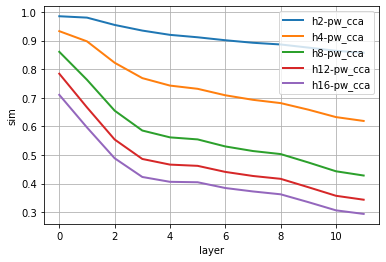

In [13]:
all_sim_2 = [0.9187088429795269, 0.918884079994578, 0.891799213239323, 0.8779517952055298, 0.8653631223084935, 0.8574980977437027, 0.8515642165716268, 0.8456090334885624, 0.8415977491881907, 0.8356827960661836, 0.8306548540554762, 0.8270708692882262]
all_sim_4 = [0.8014523527150887, 0.7966951362063723, 0.7415530244756474, 0.704569795621881, 0.6833356616522858, 0.6724398743067561, 0.6562797794285294, 0.6440836077488089, 0.6351085286699356, 0.6213446210511264, 0.6050624769301126, 0.5961276247722869]
all_sim_8 = [0.7415138486240586, 0.6759015377725685, 0.5955528405855316, 0.5437097661409039, 0.5224512025618451, 0.514440737965506, 0.49414314260921277, 0.480282860860156, 0.47193692779617546, 0.45040953524189026, 0.4273212771129386, 0.4149761983277959]
all_sim_12 = [0.6881734480920833, 0.5976512794058289, 0.5115956896571033, 0.45771504804816576, 0.4393462748425223, 0.43368979455597867, 0.4153647194239529, 0.40263864336180527, 0.3945435500228368, 0.3708841106216197, 0.3467284126380194, 0.33462159849970396]
all_sim_16 = [0.6308978743648885, 0.5433486111192773, 0.457149482142854, 0.40275009277661866, 0.3866147956516155, 0.3837155796936596, 0.36550487201825443, 0.3542407908889238, 0.34547117865797555, 0.32294391493871294, 0.2987434788109477, 0.287107493006903]
# layer_sim(type="all_cca", head_num=2)
# layer_sim(type="all_cca", head_num=4)
# layer_sim(type="all_cca", head_num=8)
# layer_sim(type="all_cca", head_num=12)
# layer_sim(type="all_cca", head_num=16)
type = "all_cca"
_plot_helper(all_sim_2, 'h'+str(2)+'-'+type, "layer", "sim")
_plot_helper(all_sim_4, 'h'+str(4)+'-'+type, "layer", "sim")
_plot_helper(all_sim_8, 'h'+str(8)+'-'+type, "layer", "sim")
_plot_helper(all_sim_12, 'h'+str(12)+'-'+type, "layer", "sim")
_plot_helper(all_sim_16, 'h'+str(16)+'-'+type, "layer", "sim")
plt.grid()
plt.show()


sv_sim_2 = [0.9052838366073211, 0.8794981832658003, 0.8368443382785697, 0.7843951421044024, 0.7748915460693572, 0.7860848258160602, 0.7864373115571056, 0.7912479076543528, 0.8116088185662322, 0.7738156905549469, 0.709701156278687, 0.6630952866364712]
sv_sim_4 = [0.8039910419235855, 0.7428354714493282, 0.6633576797959221, 0.5967964379725602, 0.5945718948122158, 0.6021966569545661, 0.5954143419453957, 0.6022360179611495, 0.5994014963089292, 0.5546434927167778, 0.48254600007035164, 0.44290050432539707]
sv_sim_8 = [0.6841798866713782, 0.6069869245583165, 0.512657538595446, 0.45231873034208303, 0.4447007989242409, 0.4497159506125011, 0.44233108003131655, 0.44096225712347714, 0.432186202950345, 0.38867974935200494, 0.3347994224019101, 0.30702758187626933]
sv_sim_12 = [0.6064797170102098, 0.5310389236309442, 0.4408070776636767, 0.3815997701041203, 0.3773262404360766, 0.38135087135219853, 0.37028541916894325, 0.3681940136257429, 0.35701094853861587, 0.31994968099125987, 0.27692759554048674, 0.2560132308149181]
sv_sim_16 = [0.5590945767691579, 0.4854345676179023, 0.4018061568539673, 0.3458768771661229, 0.33784960875256564, 0.3424970602583796, 0.3296833002144122, 0.3246361883531366, 0.31549341892935157, 0.2822164035565784, 0.24615787791792937, 0.22970708565417525]
# layer_sim(type="sv_cca", head_num=2)
# layer_sim(type="sv_cca", head_num=4)
# layer_sim(type="sv_cca", head_num=8)
# layer_sim(type="sv_cca", head_num=12)
# layer_sim(type="sv_cca", head_num=16)
type = "sv_cca"
_plot_helper(sv_sim_2, 'h'+str(2)+'-'+type, "layer", "sim")
_plot_helper(sv_sim_4, 'h'+str(4)+'-'+type, "layer", "sim")
_plot_helper(sv_sim_8, 'h'+str(8)+'-'+type, "layer", "sim")
_plot_helper(sv_sim_12, 'h'+str(12)+'-'+type, "layer", "sim")
_plot_helper(sv_sim_16, 'h'+str(16)+'-'+type, "layer", "sim")
plt.grid()
plt.show()


# pw_sim_2 = [0.9052838366073211, 0.8794981832658003, 0.8368443382785697, 0.7843951421044024, 0.7748915460693572, 0.7860848258160602, 0.7864373115571056, 0.7912479076543528, 0.8116088185662322, 0.7738156905549469, 0.709701156278687, 0.6630952866364712]
# pw_sim_4 = [0.8039910419235855, 0.7428354714493282, 0.6633576797959221, 0.5967964379725602, 0.5945718948122158, 0.6021966569545661, 0.5954143419453957, 0.6022360179611495, 0.5994014963089292, 0.5546434927167778, 0.48254600007035164, 0.44290050432539707]
# pw_sim_8 = [0.6841798866713782, 0.6069869245583165, 0.512657538595446, 0.45231873034208303, 0.4447007989242409, 0.4497159506125011, 0.44233108003131655, 0.44096225712347714, 0.432186202950345, 0.38867974935200494, 0.3347994224019101, 0.30702758187626933]
# pw_sim_12 = [0.6064797170102098, 0.5310389236309442, 0.4408070776636767, 0.3815997701041203, 0.3773262404360766, 0.38135087135219853, 0.37028541916894325, 0.3681940136257429, 0.35701094853861587, 0.31994968099125987, 0.27692759554048674, 0.2560132308149181]
# pw_sim_16 = [0.5590945767691579, 0.4854345676179023, 0.4018061568539673, 0.3458768771661229, 0.33784960875256564, 0.3424970602583796, 0.3296833002144122, 0.3246361883531366, 0.31549341892935157, 0.2822164035565784, 0.24615787791792937, 0.22970708565417525]
layer_sim(type="pw_cca", head_num=2)
layer_sim(type="pw_cca", head_num=4)
layer_sim(type="pw_cca", head_num=8)
layer_sim(type="pw_cca", head_num=12)
layer_sim(type="pw_cca", head_num=16)
# type = "pw_cca"
# _plot_helper(pw_sim_2, 'h'+str(2)+'-'+type, "layer", "sim")
# _plot_helper(pw_sim_4, 'h'+str(4)+'-'+type, "layer", "sim")
# _plot_helper(pw_sim_8, 'h'+str(8)+'-'+type, "layer", "sim")
# _plot_helper(pw_sim_12, 'h'+str(12)+'-'+type, "layer", "sim")
# _plot_helper(pw_sim_16, 'h'+str(16)+'-'+type, "layer", "sim")
plt.grid()
plt.show()